In [754]:
import os
import torch
import pandas as pd
import math
import skimage
import random
from PIL import Image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from transform import *
from data import *

In [755]:
path_300w = '/home/whale/dataset/Landmark/300W'
path_train = os.path.join(path_300w, "train.xml")
path_test = os.path.join(path_300w, "test.xml")
path_all = os.path.join(path_300w, "all.xml")
composed = transforms.Compose([CropByLDK(1.4), Flip(), Rotate(-90), RandomCrop(), Rescale((100,100)), ToTensor()])
#inall = Ldk_300W_Dataset(path_all,path_300w)
#train = Ldk_300W_Dataset(path_train, path_300w)
test = Ldk_300W_Dataset(path_test, path_300w, composed)

In [756]:
dataloader = DataLoader(test, batch_size=4, shuffle=False, num_workers=4)

/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled 

(0, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(1, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))


/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled 

(2, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(3, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(4, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(5, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(6, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(7, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(8, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(9, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))
(10, torch.Size([4, 3, 100, 100]), torch.Size([4, 68, 2]))


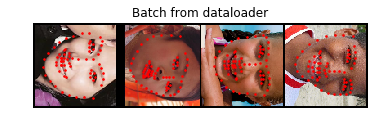

In [757]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 10:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break